In [1]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import copy

# Loading the dataset

In [2]:
df = pd.Series()
df['raw'] = pd.read_csv('./Data/Annual_Parking_Study_Data.csv')
df['raw'].shape

/home/bok/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(95218, 24)

In [3]:
df['raw'].iloc[0]

Elmntkey                                                            1577
Study_Area                                            12th Ave - Weekday
Sub_Area                                                             NaN
Study Date                                                      4/8/2014
Study_Time                                                       2:00 PM
Side                                                                   W
Unitdesc                  12TH AVE BETWEEN E COLUMBIA ST AND E MARION ST
Parking_Category                                            Paid Parking
Peak Hour_SDOT                                                       NaN
Parking_Spaces                                                         8
Total_Vehicle_Count                                                    9
Dp_Count                                                               7
Rpz_Count                                                            NaN
TG_Car2Go                                          

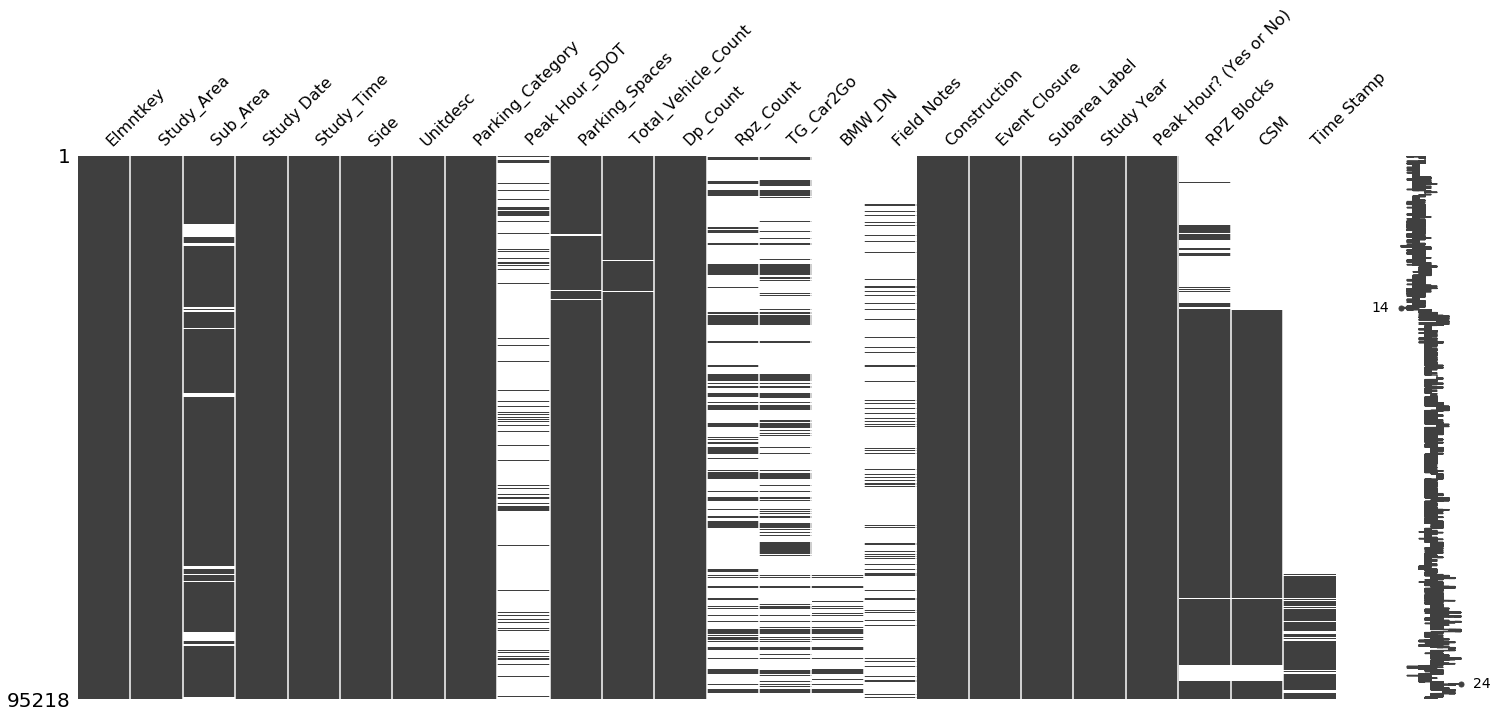

In [4]:
msno.matrix(df['raw'])

In [5]:
NA = df['raw'].shape[0] - df['raw'].dropna().shape[0]
print('Amount of lines containing N/A:\t\t{}'.format(NA))
print('Percent of lines containing N/A:\t{:.2f}%'.format(100*NA/df['raw'].shape[0]))

Amount of lines containing N/A:		95108
Percent of lines containing N/A:	99.88%


After loading in the dataset, i notice column 21 has a value problem.  
By inspecting the missing value matrix, and the percent of rows containing missing values, i see that alot of work has t be done, to prepare the dataset for use.

# Selecting data

We should end up with a dataframe, resembling the one shown below. This is to simulate the data collected by the machine vision.


|Attibute Name|Description|
|-------------|-----------|
|Time_Stamp   |The time and year of the observation.|
|Weekday      |Yes if the observation was made on a weekday, No if it was in a weekend.|
|Area         |The area the observation was made. This is on a larger scale, E.G China Town|
|Sub_Area     |The parking spot observed|
|Free_Spots   |The number of availible spots|
|Used_Spots   |The number of used spots|
|Full%        |How full the area was in percent|

In [6]:
# create the dataframe
df['select'] = pd.DataFrame()



## Time_Stamp and Weekday
Firstly, i will check out the columns which resembles time from the original dataset.

In [7]:
df['raw'][['Time Stamp', 'Study_Time', 'Study Date', 'Study Year']].dropna().head()

,Time Stamp,Study_Time,Study Date,Study Year
36373,0.894028,9:00 PM,5/24/2016,2016
72494,0.754861,6:00 PM,4/5/2016,2016
72647,0.793750,7:00 PM,4/5/2016,2016
72973,0.877778,9:00 PM,4/5/2016,2016
73339,0.638194,3:00 PM,4/5/2016,2016


The time stamp we are looking for, is found by combining the columns Study_Time and Study Year

In [8]:
df['select']['Time_Stamp'] = pd.to_datetime(df['raw']['Study_Time'] + ' ' + df['raw']['Study Date'])

# for reference the same column will be added to the raw dataframe
df['raw']['Time_Stamp'] = pd.to_datetime(df['raw']['Study_Time'] + ' ' + df['raw']['Study Date'])

In [9]:
df['select'].head()

,Time_Stamp
0,2014-04-08 14:00:00
1,2014-04-08 15:00:00
2,2014-04-08 13:00:00
3,2014-04-08 09:00:00
4,2014-04-08 12:00:00


Now the time stamp is in the right format, the day column can be created, by checking the calender date of the timestamp.

In [10]:
di = {0: 'Yes',
      1: 'Yes',
      2: 'Yes',
      3: 'Yes',
      4: 'Yes',
      5: 'No',
      6: 'No'}

df['select']['Weekday'] = df['select']['Time_Stamp'].dt.weekday.replace(di)

In [11]:
df['select'].head()

,Time_Stamp,Weekday
0,2014-04-08 14:00:00,Yes
1,2014-04-08 15:00:00,Yes
2,2014-04-08 13:00:00,Yes
3,2014-04-08 09:00:00,Yes
4,2014-04-08 12:00:00,Yes


## Area and Sub_Area

First i will check the columns from the original dataset containing area information.

In [12]:
df['raw'][['Study_Area', 'Sub_Area', 'Side', 'Unitdesc','Subarea Label']].dropna().head()

,Study_Area,Sub_Area,Side,Unitdesc,Subarea Label
208,Ballard - Weekday,Periphery,S,NW 57TH ST BETWEEN 22ND AVE NW AND 24TH AVE NW,Ballard - Weekday (Periphery Subarea)
209,Ballard - Weekday,Periphery,S,NW 57TH ST BETWEEN 22ND AVE NW AND 24TH AVE NW,Ballard - Weekday (Periphery Subarea)
210,Ballard - Weekday,Periphery,S,NW 57TH ST BETWEEN 22ND AVE NW AND 24TH AVE NW,Ballard - Weekday (Periphery Subarea)
211,Ballard - Weekday,Periphery,SW,BARNES AVE NW BETWEEN 17TH AVE NW AND NW MARKE...,Ballard - Weekday (Periphery Subarea)
212,Ballard - Weekday,Periphery,NE,BARNES AVE NW BETWEEN 17TH AVE NW AND NW MARKE...,Ballard - Weekday (Periphery Subarea)


From this, i see that the information i am looking for resides in Study_Area and Unitdesc. Unitdesc should be taken as is, being renamed to Sub_Area, and Study_Area should be sliced before the - {weekday} prefix, and renamed to Area.

In [13]:
# splitting the string, and saving it in a new column
df['select']['Area'] =df['raw']['Study_Area'].str.split('-').str[0]

# saving the Sub_Area column
df['select']['Sub_Area'] = df['raw']['Unitdesc']

In [14]:
df['select'].shape

(95218, 4)

## Parking spot information

Here the used_spots and free_spots, can almost directly be taken from the dataset. Here i have to deal with the fact that most entries are reported multiple times, with the Side column.

In [15]:
print('Before operation')
print(df['select'].shape)

# drop duplicates
df['droped'] = df['select'].drop_duplicates()

print('\nAfter operation')
print(df['droped'].shape)

Before operation
(95218, 4)

After operation
(42891, 4)


In [16]:
df['droped']= df['droped'].set_index('Time_Stamp')
df['droped'].sort_index(inplace=True)

Now the columns can be created

In [17]:
temp = df['raw'].groupby(['Time_Stamp','Unitdesc',], as_index=False)['Parking_Spaces','Total_Vehicle_Count'].sum()
temp = temp.set_index('Time_Stamp')
temp.sort_index(inplace=True)
temp.shape

(42891, 3)

In [18]:
df['droped']['Free_Spots'] = temp['Parking_Spaces']
df['droped']['Used_Spots'] = temp['Total_Vehicle_Count']
df['droped']['Full%'] = round(df['droped']['Used_Spots']/(df['droped']['Free_Spots']+df['droped']['Used_Spots'])*100)
df['droped'].head()

,Weekday,Area,Sub_Area,Free_Spots,Used_Spots,Full%
Time_Stamp,,,,,,
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E MARION ST AND E SPRING ST,12.0,0.0,0.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E COLUMBIA ST AND E MARION ST,13.0,7.0,35.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E SPRING ST AND E MADISON ST,15.0,4.0,21.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E JAMES CT AND E CHERRY ST,4.0,2.0,33.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,8.0,0.0,0.0


# Mising values

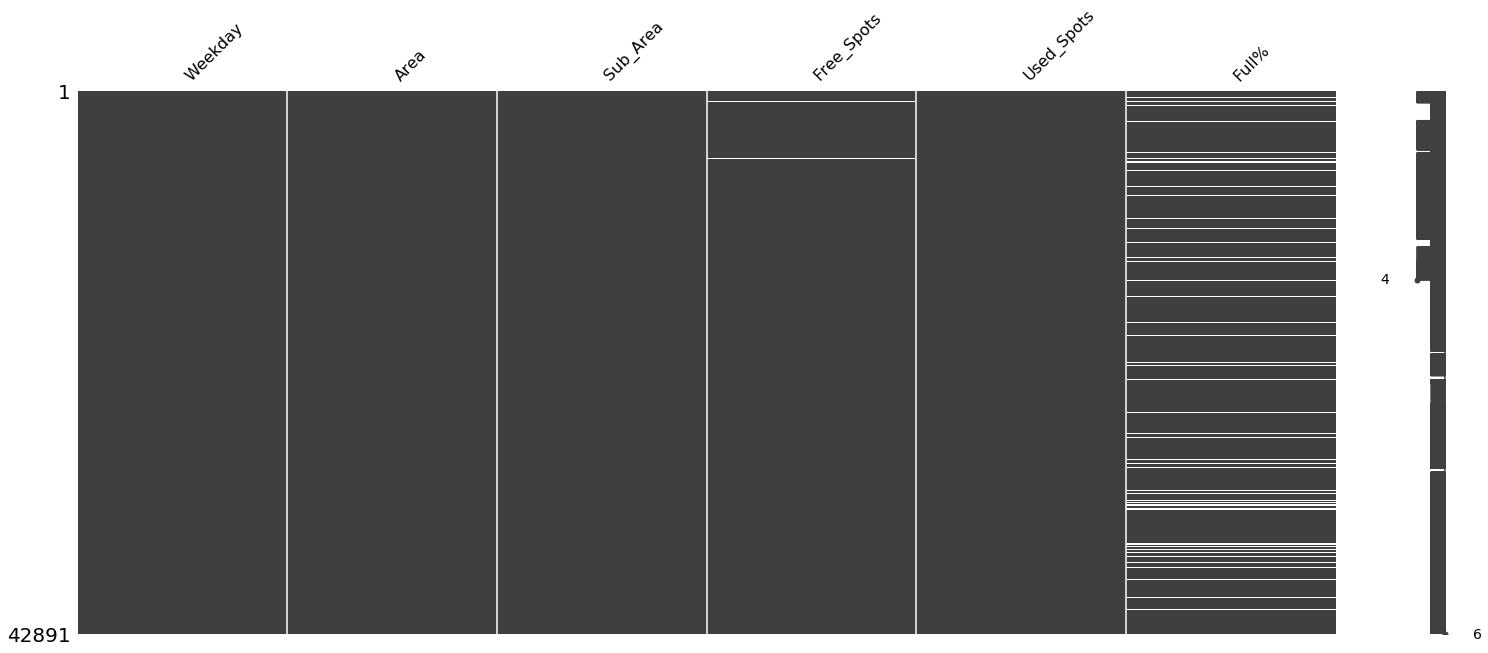

In [19]:
msno.matrix(df['droped'])

In [21]:
NA = df['droped'].shape[0] - df['droped'].dropna().shape[0]
print('Amount of lines containing N/A:\t\t{}'.format(NA))
print('Percent of lines containing N/A:\t{:.2f}%'.format(100*NA/df['raw'].shape[0]))

Amount of lines containing N/A:		4182
Percent of lines containing N/A:	4.39%


I see that a few empty rows resides in the Free_Spots column. This is acceptable, and these columns will be droped.
The rest resides in the newly created Full%. The way this column is created, will create N/A only if both Free_Spots and Used_Spots are 0. When this situaton arises, it means there are 0 legal parking spots aka the parking lot is closed for some reason. It is deemed suitable to drop all the missing rows.

In [22]:
df['final'] = df['droped'].dropna()

In [23]:
df['final'].shape

(38709, 6)

In [24]:
df['final'].to_csv('./Data/clean.csv')